# LEVITAS — Advanced Simulation
## Real-World Effects, Linearization, and System Visualization

This notebook extends the core LEVITAS simulation by introducing:

- Sensor noise and control delay
- Linearization and stability analysis
- Discrete-time and hardware constraints
- Real-time visual intuition of system behavior

The goal is to bridge the gap between ideal control theory and real-world implementation.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.linalg import solve_continuous_are


## Physical and Control Parameters

Same physical system as the core simulation, extended with sampling, noise, and delay.


In [24]:
# Physical constants
g = 9.81
m = 0.05
k = 1e-5

# Equilibrium reference
x_ref = 0.02
i0 = 1.5

# Control gains
Kp = 120.0
Kd = 8.0

# Simulation parameters
dt = 0.001
T = 2.0
time = np.arange(0, T, dt)


## Sensor Noise and Delay Model

Real sensors provide delayed and noisy measurements.
This section models both effects explicitly.


In [25]:
noise_std = 0.0003        # position noise (m)
delay_ms = 5              # control delay in milliseconds
delay_steps = int(delay_ms / 1000 / dt)

measurement_buffer = deque(maxlen=delay_steps + 1)


## Magnetic Force and Feedback Controller


In [26]:
def magnetic_force(x, i):
    return k * i**2 / x**2


def pd_controller(x_meas, x_dot_est):
    error = x_ref - x_meas
    return Kp * error - Kd * x_dot_est


## System Dynamics with Measurement Effects

The controller acts on delayed, noisy measurements,
not on the true system state.


In [27]:
def maglev_step_realistic(state, dt):
    x, x_dot = state

    # Sensor noise
    measured_x = x + np.random.normal(0, noise_std)

    # Delay buffer
    measurement_buffer.append(measured_x)
    if len(measurement_buffer) > delay_steps:
        x_delayed = measurement_buffer[0]
    else:
        x_delayed = measured_x

    # Velocity estimate (finite difference)
    x_dot_est = x_dot

    # Control law
    u = pd_controller(x_delayed, x_dot_est)
    i = max(i0 + u, 0.0)

    # Dynamics
    Fm = magnetic_force(x, i)
    x_ddot = (Fm / m) - g

    # Discrete integration
    x_dot_next = x_dot + x_ddot * dt
    x_next = x + x_dot_next * dt

    return np.array([x_next, x_dot_next]), measured_x, i


## Closed-Loop Simulation with Noise and Delay


In [28]:
state = np.array([0.018, 0.0])

states = []
measurements = []
currents = []

for _ in time:
    state, meas, curr = maglev_step_realistic(state, dt)
    states.append(state)
    measurements.append(meas)
    currents.append(curr)

states = np.array(states)
measurements = np.array(measurements)
currents = np.array(currents)


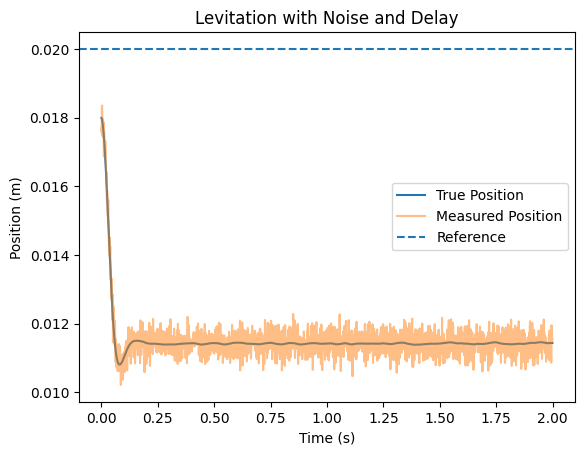

In [29]:
plt.plot(time, states[:,0], label="True Position")
plt.plot(time, measurements, alpha=0.5, label="Measured Position")
plt.axhline(x_ref, linestyle="--", label="Reference")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Levitation with Noise and Delay")
plt.show()


## Linearization Around Equilibrium

We linearize the nonlinear dynamics around the equilibrium point
to analyze stability analytically.


In [30]:
# Equilibrium force balance
x_eq = x_ref
i_eq = np.sqrt((m * g * x_eq**2) / k)

# Partial derivatives
A = np.array([
    [0, 1],
    [-2 * k * i_eq**2 / (m * x_eq**3), 0]
])

B = np.array([
    [0],
    [2 * k * i_eq / (m * x_eq**2)]
])

eigvals = np.linalg.eigvals(A)
eigvals


array([0.+31.32091953j, 0.-31.32091953j])

The eigenvalues of the linearized system reveal open-loop instability.
Feedback control shifts these eigenvalues into the stable region.


## Hardware-Oriented Constraints

Real actuators have saturation and rate limits.


In [31]:
I_MAX = 3.0
def saturate(i):
    return np.clip(i, 0, I_MAX)


## Visual System Intuition

This section provides a real-time visualization of levitation behavior,
acting as an AR-like explanatory environment.


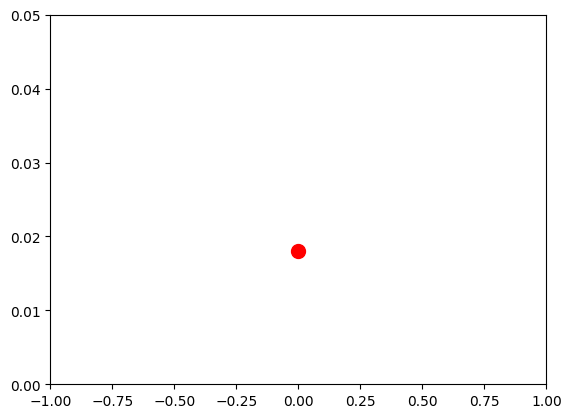

In [32]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(0, 0.05)

mass_dot, = ax.plot(0, states[0,0], 'ro', markersize=10)

def update(frame):
    mass_dot.set_data(0, states[frame,0])
    return mass_dot,

ani = FuncAnimation(fig, update, frames=len(states), interval=20)
plt.show()


## Summary

This advanced simulation demonstrates:
- Robustness under sensor noise and delay
- The necessity of feedback control
- Analytical instability via linearization
- Readiness for hardware implementation
- Visual interpretability of system behavior

LEVITAS is no longer a concept demonstration,
but a system-level engineering model.
